In [1]:
import librosa
import os, gc
import numpy as np
import random
import itertools

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
PROJECT_PATH='/home/hmenn/Workspace/CSE455_MachineLearning_2018/Final_MusicClassification'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6,6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def extractMfccFeature(_path=None, _offset=12, _duration=6):
    try:
        # returns signal and sample rate
        signal, sr = librosa.load(path=_path, offset=_offset, duration=_duration)
                
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        l = mfccs.shape[1]
        mfccs = mfccs[:, int(0.2 * l):int(0.8 * l)]

        mean = mfccs.mean(axis=1)
        covar = np.cov(mfccs, rowvar=1)

        mean.resize(1, mean.shape[0])
        # it returns matrix.. not useful for machine learning algorithms except KNN
        npArray = np.concatenate((mean, covar), axis=0)
        return npArray.flatten()
    except Exception as e:
        print ("Error accured" + str(e))
        return None

In [5]:
Y = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
     'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

Y_str = {0:'metal', 1:'disco', 2:'classical', 3:'hiphop', 4:'jazz',
     5:'country', 6:'pop', 7:'blues', 8:'reggae', 9:'rock'}

Y_basic = {'blues': 0, 'classical': 1, 'jazz': 2, 'pop': 3}
Y_str_basic = ['blues','classical','jazz','pop']

In [6]:
%%time
walk_dir = "genres"

all_input_data = []
all_input_class = []

basic_data = []
basic_class = []

for root, subdirs, files in os.walk(walk_dir):
    print("Walk on dir:",root,'Total File:',len(files))
    for filename in files:
        if filename.endswith('.au'):
            file_path = os.path.join(root, filename)
            feature = extractMfccFeature(file_path)

            all_input_data.append(feature)
            all_input_class.append(Y[filename.split('.')[0]])

            if root=='genres/classical' or root=='genres/jazz' or root=='genres/blues' or root=='genres/pop':
                basic_data.append(feature)
                basic_class.append(Y_basic[filename.split('.')[0]])

Walk on dir: genres Total File: 0
Walk on dir: genres/pop Total File: 100
Walk on dir: genres/blues Total File: 100
Walk on dir: genres/classical Total File: 100
Walk on dir: genres/country Total File: 100
Walk on dir: genres/hiphop Total File: 100
Walk on dir: genres/rock Total File: 100
Walk on dir: genres/reggae Total File: 100
Walk on dir: genres/metal Total File: 100
Walk on dir: genres/disco Total File: 100
Walk on dir: genres/jazz Total File: 100
CPU times: user 10min 7s, sys: 2min 55s, total: 13min 3s
Wall time: 9min 38s


### Shuffling all data

In [7]:
%%time
print("Shuffle input data to get better results")

all_input_shuffledData = np.asarray(all_input_data)
all_input_shuffledClass = np.asarray(all_input_class)

s = np.arange(all_input_shuffledData.shape[0])
np.random.shuffle(s)

all_input_shuffledData = all_input_shuffledData[s]
all_input_shuffledClass = all_input_shuffledClass[s]

basic_shuffledData = np.asarray(basic_data)
basic_shuffledClass = np.asarray(basic_class)

s = np.arange(basic_shuffledData.shape[0])
np.random.shuffle(s)

basic_shuffledData = basic_shuffledData[s]
basic_shuffledClass = basic_shuffledClass[s]

print("->all_input_shuffledData:",all_input_shuffledData.shape)
print("->all_input_shuffledClass:",all_input_shuffledClass.shape)

print("->basic_shuffledData:",basic_shuffledData.shape)
print("->basic_shuffledClass:",basic_shuffledClass.shape)

Shuffle input data to get better results
->all_input_shuffledData: (1000, 420)
->all_input_shuffledClass: (1000,)
->basic_shuffledData: (400, 420)
->basic_shuffledClass: (400,)
CPU times: user 11.8 ms, sys: 13.1 ms, total: 24.9 ms
Wall time: 10.6 ms


In [8]:
yt_data = []
yt_class = []

yt_data_basic = []
yt_class_basic = []

# CLASSICAL 
print('Classical')
classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=14, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])
yt_data_basic.append(classical)
yt_class_basic.append(Y_basic['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=20, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])
yt_data_basic.append(classical)
yt_class_basic.append(Y_basic['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=28, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])
yt_data_basic.append(classical)
yt_class_basic.append(Y_basic['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=24, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])
yt_data_basic.append(classical)
yt_class_basic.append(Y_basic['classical'])

# JAZZ
print('Jazz')
jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=2, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])
yt_data_basic.append(jazz)
yt_class_basic.append(Y_basic['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=16, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])
yt_data_basic.append(jazz)
yt_class_basic.append(Y_basic['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=28, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])
yt_data_basic.append(jazz)
yt_class_basic.append(Y_basic['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=7, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])
yt_data_basic.append(jazz)
yt_class_basic.append(Y_basic['jazz'])

# ROCK
print('Rock')
rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=15, _duration=6)
yt_data.append(rock)
yt_class.append(Y['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=21, _duration=6)
yt_data.append(rock)
yt_class.append(Y['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=28, _duration=6)
yt_data.append(rock)
yt_class.append(Y['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=25, _duration=6)
yt_data.append(rock)
yt_class.append(Y['rock'])

# HIP HOP
print('HipHop')
hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=5, _duration=6)
yt_data.append(hiphop)
yt_class.append(Y['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=28, _duration=6)
yt_data.append(hiphop)
yt_class.append(Y['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=20, _duration=6)
yt_data.append(hiphop)
yt_class.append(Y['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=12, _duration=6)
yt_data.append(hiphop)
yt_class.append(Y['hiphop']) 

# DISCO
print('Disco')
disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=2, _duration=6)
yt_data.append(disco)
yt_class.append(Y['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=16, _duration=6)
yt_data.append(disco)
yt_class.append(Y['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=28, _duration=6)
yt_data.append(disco)
yt_class.append(Y['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=7, _duration=6)
yt_data.append(disco)
yt_class.append(Y['disco'])

# POP
print('Pop')
pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=2, _duration=6)
yt_data.append(pop)
yt_class.append(Y['pop'])
yt_data_basic.append(pop)
yt_class_basic.append(Y_basic['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=16, _duration=6)
yt_data.append(pop)
yt_class.append(Y['pop'])
yt_data_basic.append(pop)
yt_class_basic.append(Y_basic['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=28, _duration=6)
yt_data.append(pop)
yt_class.append(Y['pop'])
yt_data_basic.append(pop)
yt_class_basic.append(Y_basic['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=7, _duration=6)
yt_data.append(pop)
yt_class.append(Y['pop'])
yt_data_basic.append(pop)
yt_class_basic.append(Y_basic['pop'])

# BLUES
print('Blues')
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.m4a', _offset=22, _duration=6)
yt_data.append(blues)
yt_class.append(Y['blues'])
yt_data_basic.append(blues)
yt_class_basic.append(Y_basic['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.m4a', _offset=46, _duration=6)
yt_data.append(blues)
yt_class.append(Y['blues'])
yt_data_basic.append(blues)
yt_class_basic.append(Y_basic['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.m4a', _offset=123, _duration=6)
yt_data.append(blues)
yt_class.append(Y['blues'])
yt_data_basic.append(blues)
yt_class_basic.append(Y_basic['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.m4a', _offset=78, _duration=6)
yt_data.append(blues)
yt_class.append(Y['blues']) 
yt_data_basic.append(blues)
yt_class_basic.append(Y_basic['blues'])

# COUNTRY
print('Country')
country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=123, _duration=6)
yt_data.append(country)
yt_class.append(Y['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=425, _duration=6)
yt_data.append(country)
yt_class.append(Y['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=12, _duration=6)
yt_data.append(country)
yt_class.append(Y['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=728, _duration=6)
yt_data.append(country)
yt_class.append(Y['country'])

# REGGAE
print('Reggae')
reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=321, _duration=6)
yt_data.append(reggae)
yt_class.append(Y['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=423, _duration=6)
yt_data.append(reggae)
yt_class.append(Y['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=56, _duration=6)
yt_data.append(reggae)
yt_class.append(Y['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=124, _duration=6)
yt_data.append(reggae)
yt_class.append(Y['reggae'])

Classical
Jazz
Rock
HipHop
Disco
Pop
Blues
Country
Reggae


### KNN

KNN Score:  0.365
CPU times: user 1.08 s, sys: 153 ms, total: 1.23 s
Wall time: 1.15 s


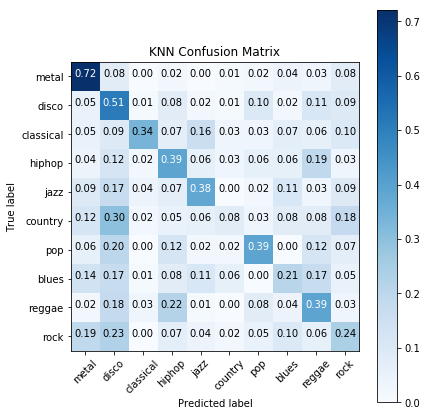

In [9]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(knn.predict(X_test))

    yt_guess.extend(knn.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)

plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='KNN Confusion Matrix')
print("KNN Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='KNN YT Confusion Matrix')
print("KNN Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

KNN Score:  0.6025
KNN Youtube Score:  1.0
CPU times: user 485 ms, sys: 141 ms, total: 626 ms
Wall time: 422 ms


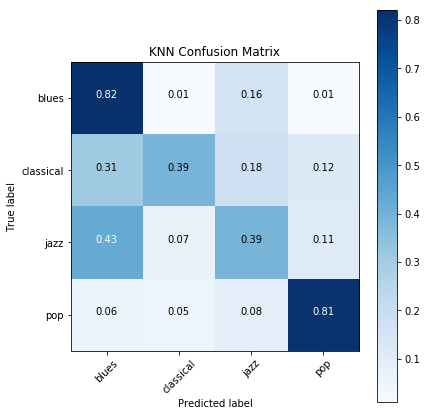

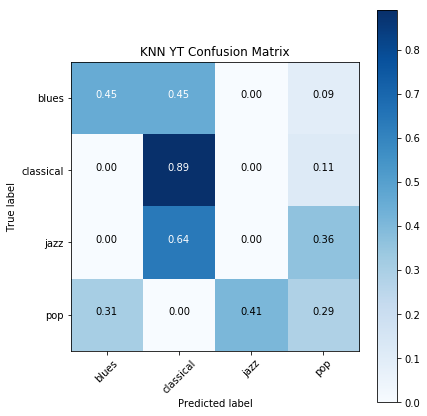

In [10]:
%%time
kf = KFold(n_splits=5)

basic_guess = []
basic_actual = []

yt_guess_basic = []
yt_actual_basic = []

for trainIndex, testIndex in kf.split(basic_shuffledData):
    X_train, X_test = basic_shuffledData[trainIndex], basic_shuffledData[testIndex]
    y_train, y_test = basic_shuffledClass[trainIndex], basic_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train,y_train)
    
    basic_actual.extend(y_test)
    basic_guess.extend(knn.predict(X_test))

    yt_guess_basic.extend(knn.predict(yt_data_basic))
    yt_actual_basic.extend(yt_class_basic)

coeff = confusion_matrix(basic_actual, basic_guess)

plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='KNN Confusion Matrix')
print("KNN Score: ", accuracy_score(basic_actual, basic_guess))


coeff = confusion_matrix(yt_guess_basic, yt_actual_basic)
plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='KNN YT Confusion Matrix')
print("KNN Youtube Score: ", accuracy_score(yt_guess_basic, yt_guess_basic))


### SVM

SVM Score:  0.505
CPU times: user 26.8 s, sys: 181 ms, total: 27 s
Wall time: 27.2 s


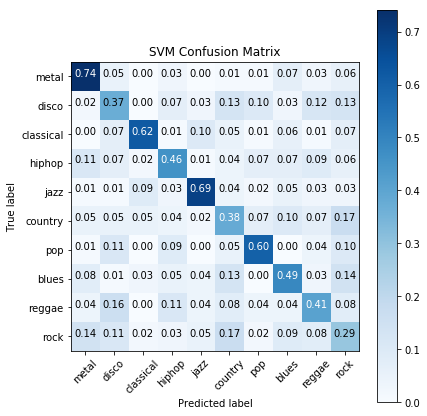

In [11]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(svm1.predict(X_test))

    yt_guess.extend(svm1.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='SVM Confusion Matrix')
print("SVM Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='SVM YT Confusion Matrix')
print("SVM Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

SVM Score:  0.83
KNN Youtube Score:  1.0
CPU times: user 3.04 s, sys: 190 ms, total: 3.23 s
Wall time: 2.99 s


/home/hmenn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/hmenn/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


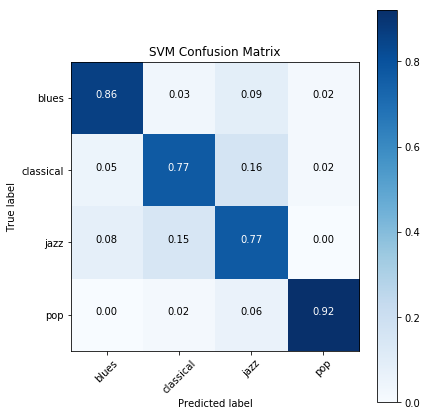

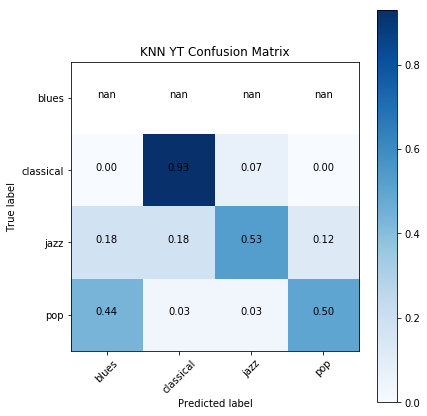

In [12]:
%%time
kf = KFold(n_splits=5)

basic_guess = []
basic_actual = []

yt_guess_basic = []
yt_actual_basic = []

for trainIndex, testIndex in kf.split(basic_shuffledData):
    X_train, X_test = basic_shuffledData[trainIndex], basic_shuffledData[testIndex]
    y_train, y_test = basic_shuffledClass[trainIndex], basic_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    basic_actual.extend(y_test)
    basic_guess.extend(svm1.predict(X_test))

    yt_guess_basic.extend(svm1.predict(yt_data_basic))
    yt_actual_basic.extend(yt_class_basic)

coeff = confusion_matrix(basic_actual, basic_guess)

plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='SVM Confusion Matrix')
print("SVM Score: ", accuracy_score(basic_actual, basic_guess))


coeff = confusion_matrix(yt_guess_basic, yt_actual_basic)
plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='SVM YT Confusion Matrix')
print("SVM Youtube Score: ", accuracy_score(yt_guess_basic, yt_guess_basic))


### Decision Tree

Decision Tree Score:  0.354
CPU times: user 2.05 s, sys: 90.4 ms, total: 2.14 s
Wall time: 2.03 s


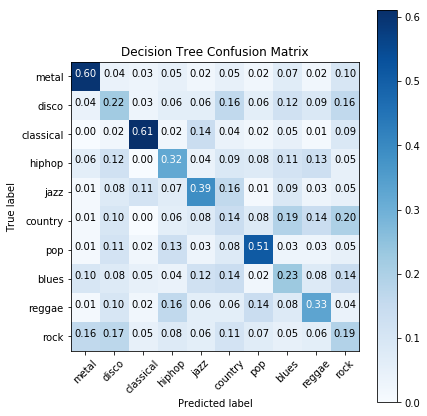

In [13]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='Decision Tree Confusion Matrix')        
print("Decision Tree Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='Decision YT Confusion Matrix')
print("Decision Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

Decision Tree Score:  0.7075
KNN Youtube Score:  0.3875
CPU times: user 665 ms, sys: 230 ms, total: 895 ms
Wall time: 618 ms


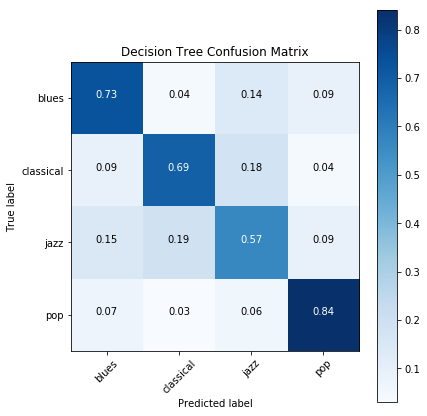

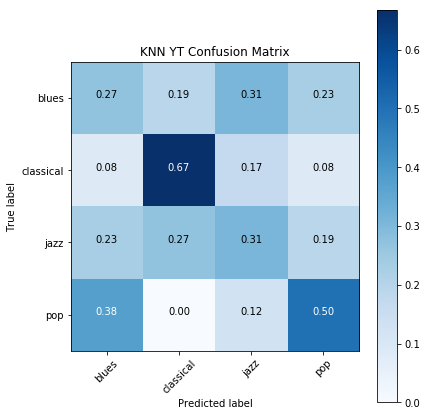

In [14]:
%%time
kf = KFold(n_splits=5)

basic_guess = []
basic_actual = []

yt_guess_basic = []
yt_actual_basic = []

for trainIndex, testIndex in kf.split(basic_shuffledData):
    X_train, X_test = basic_shuffledData[trainIndex], basic_shuffledData[testIndex]
    y_train, y_test = basic_shuffledClass[trainIndex], basic_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    basic_actual.extend(y_test)
    basic_guess.extend(dt.predict(X_test))

    yt_guess_basic.extend(dt.predict(yt_data_basic))
    yt_actual_basic.extend(yt_class_basic)

coeff = confusion_matrix(basic_actual, basic_guess)

plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='Decision Tree Confusion Matrix')
print("Decision Tree Score: ", accuracy_score(basic_actual, basic_guess))

coeff = confusion_matrix(yt_guess_basic, yt_actual_basic)
plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='Decision Tree YT Confusion Matrix')
print("Decision Tree Youtube Score: ", accuracy_score(yt_guess_basic, yt_actual_basic))

### XGBoost

XGBoost Accuracy Score: 0.635
CPU times: user 15min 18s, sys: 5.85 s, total: 15min 24s
Wall time: 6min 29s


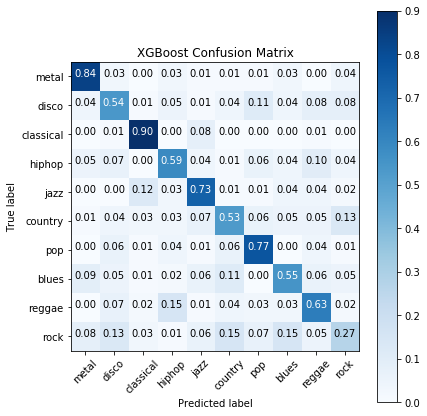

In [15]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, d_train, num_boost_round = 240)
    
    actual.extend(y_test)
    guess.extend(model.predict(d_valid))
    
    d_yt = xgb.DMatrix(yt_data, yt_class)
    yt_guess.extend(model.predict(d_yt))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='XGBoost Confusion Matrix')
print('XGBoost Accuracy Score:',accuracy_score(actual, guess))

"""
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='XGBoost YT Confusion Matrix')
print("XGBoost Youtube Score: ", accuracy_score(yt_guess, yt_actual))
"""

XGBoost Accuracy Score: 0.885
XGBoost Youtube Score:  0.3875
CPU times: user 3min 28s, sys: 1.48 s, total: 3min 30s
Wall time: 1min 31s


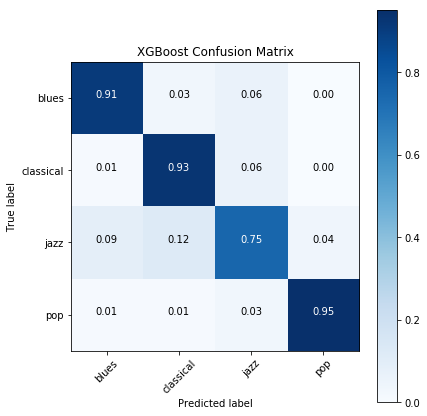

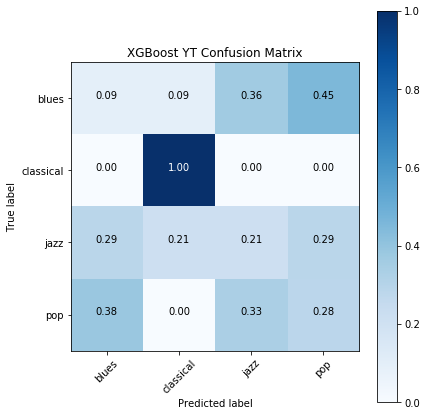

In [16]:
%%time
kf = KFold(n_splits=5)

guess_basic = []
actual_basic = []

yt_guess_basic = []
yt_actual_basic = []

for trainIndex, testIndex in kf.split(basic_shuffledData):
    X_train, X_test = basic_shuffledData[trainIndex], basic_shuffledData[testIndex]
    y_train, y_test = basic_shuffledClass[trainIndex], basic_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, d_train, num_boost_round = 240)
    
    actual_basic.extend(y_test)
    guess_basic.extend(model.predict(d_valid))
    
    d_yt = xgb.DMatrix(yt_data_basic, yt_class_basic)
    yt_guess_basic.extend(model.predict(d_yt))
    yt_actual_basic.extend(yt_class_basic)
    
coeff = confusion_matrix(actual_basic, guess_basic)
plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='XGBoost Confusion Matrix')
print('XGBoost Accuracy Score:',accuracy_score(actual_basic, guess_basic))


coeff = confusion_matrix(yt_guess_basic, yt_actual_basic)
plot_confusion_matrix(coeff, classes=Y_str_basic, normalize=True,
                      title='XGBoost YT Confusion Matrix')
print("XGBoost Youtube Score: ", accuracy_score(yt_guess_basic, yt_actual_basic))

In [17]:
# run garbage collector manually
gc.collect()

30197